In [1]:
PHONEME_KEY = "phoneme"
VISEME_KEY = "viseme"
LETTER_KEY = "letter"

In [2]:
train_with = VISEME_KEY 

# Dependencies

In [3]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import re
import ast
import sys
import cv2
import random
import json

!pip install num2words
!pip install jiwer

from jiwer import wer

## CSF
proj_data_dir = "../../proj_data/preprocessed"
proj_model_dir = "../../proj_models/"

proj_code_dir = "../classes"
sys.path.append(proj_code_dir)
from PhonemesVisemes import word_to_phonemes, phonemes_to_visemes 

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, LSTM, TimeDistributed,Bidirectional, InputLayer,Attention,Dense,Dropout,Input,Embedding,MultiHeadAttention,LayerNormalization, Concatenate, Conv1D, MaxPooling1D,GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report

!pip install datasets
from datasets import Dataset

2024-02-21 09:34:04.501870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 09:34:05.821744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/mnt/iusers01/fse-ugpgt01/compsci01/h61781jp/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [5]:
train_X_frames = []
train_X_landmarks = []
train_Y = []


test_X_frames = []
test_X_landmarks = []
test_Y = []

val_X_frames = []
val_X_landmarks = []
val_Y = []

data_mats = os.listdir(proj_data_dir)
for path in os.listdir(proj_data_dir):
    path = os.path.join(proj_data_dir, path)
    
    data_mat = loadmat(path)
    
    train_X_frames.extend(data_mat["train_data_frames"])
    train_X_landmarks.extend(data_mat["train_data_keypoints"])
    train_Y.extend(data_mat["train_labels"])


    test_X_frames.extend(data_mat["test_data_frames"])
    test_X_landmarks.extend(data_mat["test_data_keypoints"])
    test_Y.extend(data_mat["test_labels"])

    val_X_frames.extend(data_mat["val_data_frames"])
    val_X_landmarks.extend(data_mat["val_data_keypoints"])
    val_Y.extend(data_mat["val_labels"])

In [6]:
def show_data():
    print(f"Train data frames length: {np.shape(train_X_frames)}")
    print(f"Train data landmarks length: {np.shape(train_X_landmarks)}")
    print(f"Train labels length: {np.shape(train_Y)}")

    print(f"Test data frames length: {np.shape(test_X_frames)}")
    print(f"Test data landmarks length: {np.shape(test_X_landmarks)}")
    print(f"Test labels length: {np.shape(test_Y)}")

    print(f"Validation data frames length: {np.shape(val_X_frames)}")
    print(f"Validation data landmarks length: {np.shape(val_X_landmarks)}")
    print(f"Validation labels length: {np.shape(val_Y)}")

In [7]:
show_data()

Train data frames length: (52224, 21, 2048)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224, 30)
Test data frames length: (6528, 21, 2048)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528, 30)
Validation data frames length: (6528, 21, 2048)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528, 30)


## Data Encoding

In [8]:
word_set = ['ABOUT', 'AGAIN', 'AHEAD', 'ARRESTED', 'BELIEVE', 'BUSINESS', 'CHANCE', 'DESPITE', 'ELECTION', 'FAMILY', 'FIGURES', 'FOREIGN', 'FRANCE', 'GIVING', 'LATER', 'LEADERS', 'MIGHT', 'MINUTES', 'NEEDS', 'NOTHING', 'OFFICIALS', 'PAYING', 'POSSIBLE', 'POWERS', 'RIGHTS', 'SITUATION', 'STREET', 'TALKING', 'THIRD', 'THROUGH']
num_words = len(word_set)

backward_word_translations = {i: word_set[i] for i in range(num_words)}
print(backward_word_translations)

{0: 'ABOUT', 1: 'AGAIN', 2: 'AHEAD', 3: 'ARRESTED', 4: 'BELIEVE', 5: 'BUSINESS', 6: 'CHANCE', 7: 'DESPITE', 8: 'ELECTION', 9: 'FAMILY', 10: 'FIGURES', 11: 'FOREIGN', 12: 'FRANCE', 13: 'GIVING', 14: 'LATER', 15: 'LEADERS', 16: 'MIGHT', 17: 'MINUTES', 18: 'NEEDS', 19: 'NOTHING', 20: 'OFFICIALS', 21: 'PAYING', 22: 'POSSIBLE', 23: 'POWERS', 24: 'RIGHTS', 25: 'SITUATION', 26: 'STREET', 27: 'TALKING', 28: 'THIRD', 29: 'THROUGH'}


In [9]:
def revert_labels(labels):
    temp = []
    for y in labels:
        temp.append(backward_word_translations[np.argmax(y)])
    return temp

train_Y = revert_labels(labels=train_Y)
test_Y = revert_labels(labels=test_Y)
val_Y = revert_labels(labels=val_Y)

## Data Example

In [10]:
def landmarks_to_img(landmarks):
  width = 200
  height = 200
  new_frame = np.zeros((width,height))
  for ldmk in landmarks:
      new_frame = cv2.circle(
          img=new_frame,
          center=(int(ldmk[0] * width), int(ldmk[1] * height)),
          radius=2,
          thickness=1,
          color=(255,255,255),
      )
  return new_frame

def show_frames(frames, landmark: bool):
  print(np.shape(frames))
  fig, ax = plt.subplots(figsize=(18, 2))
  if(not landmark):
    row = frames[0]
    for x in range(1,len(frames)):
      row = np.concatenate((row, frames[x]), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)
  else:
    row = landmarks_to_img(frames[0])
    for x in range(1,len(frames)):
      row = np.concatenate((row, landmarks_to_img(frames[x])), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)


(21, 40, 3)
Class: DESPITE


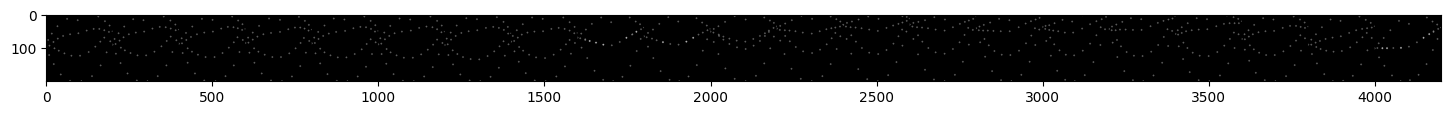

In [11]:
show_frames(frames=train_X_landmarks[0],landmark=True)
print(f"Class: {train_Y[0]}")

In [12]:
num_frames = 21

In [13]:
label_breakdown = [[x for x in word] for word in word_set]

letters = np.array([])
for label in label_breakdown:
    letters = np.concatenate((letters,label))
letters = np.unique(letters)

#One hot
# letter_encoder = keras.layers.StringLookup(
#     num_oov_indices=0, vocabulary=letters,output_mode="one_hot"
# )

#Numerical
letter_encodings = {letters[i]: (i + 1) for i in range(len(letters))}
N = len(letters) + 1
letter_encodings[" "] = N #Encode padding as the last index in the array due to how CTC handles blank space

num_encodings = {letter_encodings[key]:key for key in list(letter_encodings.keys())}
num_encodings[-1] = " "
num_encodings[0] = " "

word_encodings = {word_set[i].strip().lower(): [letter_encodings[letter] for letter in word_set[i]] for i in range(len(word_set))}

for key in word_encodings:
    while(len(word_encodings[key]) < num_frames):
        word_encodings[key].append(letter_encodings[" "])

print(f"Letters to numbers: {letter_encodings}\n")
print(f"Numbers to letters: {num_encodings}\n")
print(f"Word to numbers: {word_encodings}\n")

num_letters = N
print(f"num_letters:{num_letters}")

Letters to numbers: {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'Y': 22, ' ': 23}

Numbers to letters: {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'Y', 23: ' ', -1: ' ', 0: ' '}

Word to numbers: {'about': [1, 2, 14, 19, 18, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23], 'again': [1, 7, 1, 9, 13, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23], 'ahead': [1, 8, 5, 1, 4, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23], 'arrested': [1, 16, 16, 5, 17, 18, 5, 4, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23], 'believe': [2, 5, 11, 9, 5, 20, 5, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23], 'business': [2, 19, 17, 9, 13, 5, 17, 17, 23, 23, 23, 23, 23, 23,

In [14]:
phoneme_subset = []
for word in word_set:
    phoneme_subset.extend(word_to_phonemes(word.lower().replace(" ","")))
phoneme_subset = np.unique(phoneme_subset)

phoneme_encodings = {phoneme_subset[i]: (i + 1) for i in range(len(phoneme_subset))}

N = len(phoneme_subset) + 1
phoneme_encodings[" "] = N

reverse_phoneme_encodings = {phoneme_encodings[key]:key for key in list(phoneme_encodings.keys())}
reverse_phoneme_encodings[-1] = " "
reverse_phoneme_encodings[0] = " "

word_phoneme_encodings = {}
for word in word_set:
    lower_word = word.lower().strip().replace(" ","")
    word_phoneme_encodings[lower_word] = [phoneme_encodings[phoneme] for phoneme in word_to_phonemes(lower_word)]
    while(len(word_phoneme_encodings[lower_word]) < num_frames):
        word_phoneme_encodings[lower_word].append(phoneme_encodings[" "])

print(f"Phonemes to numbers: {phoneme_encodings}\n")
print(f"Numbers to phonemes: {reverse_phoneme_encodings}\n")
print(f"Word to numbers: {word_phoneme_encodings}\n")

num_phonemes = N
print(f"num_phonemes:{num_phonemes}")

Phonemes to numbers: {'AA1': 1, 'AE1': 2, 'AH0': 3, 'AH1': 4, 'AO1': 5, 'AW1': 6, 'AY1': 7, 'B': 8, 'CH': 9, 'D': 10, 'EH1': 11, 'ER0': 12, 'ER1': 13, 'EY1': 14, 'F': 15, 'G': 16, 'HH': 17, 'IH0': 18, 'IH1': 19, 'IH2': 20, 'IY0': 21, 'IY1': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'NG': 27, 'P': 28, 'R': 29, 'S': 30, 'SH': 31, 'T': 32, 'TH': 33, 'UW0': 34, 'UW1': 35, 'V': 36, 'Y': 37, 'Z': 38, ' ': 39}

Numbers to phonemes: {1: 'AA1', 2: 'AE1', 3: 'AH0', 4: 'AH1', 5: 'AO1', 6: 'AW1', 7: 'AY1', 8: 'B', 9: 'CH', 10: 'D', 11: 'EH1', 12: 'ER0', 13: 'ER1', 14: 'EY1', 15: 'F', 16: 'G', 17: 'HH', 18: 'IH0', 19: 'IH1', 20: 'IH2', 21: 'IY0', 22: 'IY1', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'NG', 28: 'P', 29: 'R', 30: 'S', 31: 'SH', 32: 'T', 33: 'TH', 34: 'UW0', 35: 'UW1', 36: 'V', 37: 'Y', 38: 'Z', 39: ' ', -1: ' ', 0: ' '}

Word to numbers: {'about': [3, 8, 6, 32, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39], 'again': [3, 16, 11, 26, 39, 39, 39, 39, 39, 39, 39, 39, 39, 

In [15]:
viseme_subset = []
for word in word_set:
    viseme_subset.extend(phonemes_to_visemes(word_to_phonemes(word.lower().replace(" ",""))))
viseme_subset = np.unique(viseme_subset)

viseme_encodings = {viseme_subset[i]: (i + 1)  for i in range(len(viseme_subset))}

N = len(viseme_subset) + 1
viseme_encodings[" "] = N

reverse_viseme_encodings = {viseme_encodings[key]:key for key in list(viseme_encodings.keys())}
reverse_viseme_encodings[-1] = " "
reverse_viseme_encodings[0] = " "

word_viseme_encodings = {}
for word in word_set:
    lower_word = word.lower().strip().replace(" ","")
    word_viseme_encodings[lower_word] = [viseme_encodings[vis] for vis in phonemes_to_visemes(word_to_phonemes(lower_word))]
    while(len(word_viseme_encodings[lower_word]) < num_frames):
        word_viseme_encodings[lower_word].append(viseme_encodings[" "])

print(f"Visemes to numbers: {viseme_encodings}\n")
print(f"Numbers to visemes: {reverse_viseme_encodings}\n")
print(f"Word to numbers: {word_viseme_encodings}\n")

num_visemes = N
print(f"num_visemes:{num_visemes}")

Visemes to numbers: {'aa': 1, 'ah': 2, 'ao': 3, 'ch': 4, 'eh': 5, 'er': 6, 'f': 7, 'iy': 8, 'k': 9, 'p': 10, 't': 11, 'uh': 12, 'w': 13, ' ': 14}

Numbers to visemes: {1: 'aa', 2: 'ah', 3: 'ao', 4: 'ch', 5: 'eh', 6: 'er', 7: 'f', 8: 'iy', 9: 'k', 10: 'p', 11: 't', 12: 'uh', 13: 'w', 14: ' ', -1: ' ', 0: ' '}

Word to numbers: {'about': [2, 10, 1, 12, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'again': [2, 9, 5, 9, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'ahead': [2, 9, 5, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'arrested': [6, 5, 11, 11, 2, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'believe': [10, 8, 9, 8, 7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'business': [10, 8, 11, 9, 2, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'chance': [4, 5, 9, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], 'despite': [11, 8, 

In [16]:
#Numeric
def encode_letter(letter:str):
    return letter_encodings[letter]

def encode_word(word:str, pad=False):
    word = word.lower()
    if(train_with == LETTER_KEY):
        temp = word_encodings[word.lower().replace(" ","")]
        blank_space = letter_encodings[" "]
    elif(train_with == PHONEME_KEY):
        temp = word_phoneme_encodings[word.lower().replace(" ","")]
        blank_space = phoneme_encodings[" "]
    elif(train_with == VISEME_KEY):
        temp = word_viseme_encodings[word.lower().replace(" ","")]
        blank_space = viseme_encodings[" "]

    if(pad):
        while(len(temp) < num_frames):
            temp.append(blank_space)
    return np.array(temp)

def decode_word(encoded_word):
    if(train_with == PHONEME_KEY or train_with == VISEME_KEY):
        word = []
    else:
        word = ""
    for num in encoded_word:
        if(train_with == LETTER_KEY):
            word += num_encodings[num]
        elif(train_with == PHONEME_KEY):
            word.append(reverse_phoneme_encodings[num])
        elif(train_with == VISEME_KEY):
            word.append(reverse_viseme_encodings[num])
    return word

def encode_labels(labels):
    return np.array([encode_word(label) for label in labels])

In [17]:
train_Y = encode_labels(labels=train_Y)
test_Y = encode_labels(labels=test_Y)
val_Y = encode_labels(labels=val_Y)

print(train_Y)
print(np.shape(train_Y))

[[11  8 11 ... 14 14 14]
 [11  8 11 ... 14 14 14]
 [ 7 13  5 ... 14 14 14]
 ...
 [13  1  8 ... 14 14 14]
 [11  3  9 ... 14 14 14]
 [11  3  9 ... 14 14 14]]
(52224, 21)


# Model Training

## Learning Rate Scheduler

In [18]:
initial_lr = 0.0001
epochs = 50
batch_size: int = 32
decay_rate: float = 0.95

decay_steps = int(len(train_Y)/batch_size)
print(f"decay_steps: {decay_steps}")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(proj_model_dir, "best_run.hdf5"),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr,decay_steps=decay_steps,decay_rate=decay_rate,staircase=False)

decay_steps: 1632


## Model Architecture

Model is video based & word based. It uses feature vectors extracted for each frame.

In [19]:
show_data()

Train data frames length: (52224, 21, 2048)
Train data landmarks length: (52224, 21, 40, 3)
Train labels length: (52224, 21)
Test data frames length: (6528, 21, 2048)
Test data landmarks length: (6528, 21, 40, 3)
Test labels length: (6528, 21)
Validation data frames length: (6528, 21, 2048)
Validation data landmarks length: (6528, 21, 40, 3)
Validation labels length: (6528, 21)


In [20]:
train_ds = tf.data.Dataset.from_tensor_slices(
  ((train_X_frames,train_X_landmarks), train_Y)
)
train_ds = train_ds.padded_batch(batch_size, padded_shapes=((np.shape(train_X_frames[0]),np.shape(train_X_landmarks[0])),np.shape(train_Y[0])))
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
  ((test_X_frames,test_X_landmarks), test_Y)
)
test_ds = test_ds.padded_batch(batch_size, padded_shapes=((np.shape(test_X_frames[0]),np.shape(test_X_landmarks[0])),np.shape(test_Y[0])))
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
  ((val_X_frames,val_X_landmarks), val_Y)
)
val_ds = val_ds.padded_batch(batch_size, padded_shapes=((np.shape(val_X_frames[0]),np.shape(val_X_landmarks[0])),np.shape(val_Y[0])))
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

2024-02-21 09:37:32.197025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78945 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [21]:
if(train_with == LETTER_KEY):
    num_labels = num_letters
elif(train_with == PHONEME_KEY):
    num_labels = num_phonemes
elif(train_with == VISEME_KEY):
    num_labels = num_visemes

In [22]:
## Both attention architecture
epsilon = 1e-6

input_layer_frames = Input(shape= np.shape(train_X_frames[0]), name="input_frames")
flatten_layer_frames = TimeDistributed(Flatten())(input_layer_frames)
attention_layer_frames = Attention(use_scale=True)([flatten_layer_frames,flatten_layer_frames])
norm_layer_frames = LayerNormalization(epsilon=epsilon)(flatten_layer_frames + attention_layer_frames)

input_layer_landmarks = Input(shape= np.shape(train_X_landmarks[0]), name="input_landmarks")
flatten_layer_landmarks = TimeDistributed(Flatten())(input_layer_landmarks)
dense_scale_layer = Dense(np.shape(train_X_frames[0])[-1])(flatten_layer_landmarks)
attention_layer_landmarks = Attention(use_scale=True)([dense_scale_layer,dense_scale_layer])
norm_layer_landmarks = LayerNormalization(epsilon=epsilon)(dense_scale_layer + attention_layer_landmarks)

cross_attention_layer1 = Attention(use_scale=True)([norm_layer_landmarks,norm_layer_frames])
cross_norm_layer1 = LayerNormalization(epsilon=epsilon)(cross_attention_layer1 + norm_layer_landmarks + norm_layer_frames)

cross_attention_layer2 = Attention(use_scale=True)([norm_layer_frames,norm_layer_landmarks])
cross_norm_layer2 = LayerNormalization(epsilon=epsilon)(cross_attention_layer2 + norm_layer_landmarks + norm_layer_frames)

concatenate_layer = Concatenate(axis=-1)([cross_norm_layer1,cross_norm_layer2])

#GRU layers
# gru1 = GRU(256, return_sequences=True,activation='relu')(concatenate_layer)
# gru2 = GRU(128, return_sequences=True,activation='relu')(gru1)
# gru3 = GRU(64, return_sequences=True,activation='relu')(gru2)

#Bi-LSTM layers
bilstm_layer1 = Bidirectional(LSTM(256,activation='relu', return_sequences=True))(concatenate_layer)
bilstm_layer2 = Bidirectional(LSTM(256,activation='relu', return_sequences=True))(bilstm_layer1)
bilstm_layer3 = Bidirectional(LSTM(256,activation='relu', return_sequences=True))(bilstm_layer2)

# conv_layer1 = Conv1D(1024, 3, padding='same', activation='relu')(concatenate_layer)
# dropout1 = Dropout(0.1)(conv_layer1)
# max_pooling1 = MaxPooling1D()(dropout1)

# conv_layer2 = Conv1D(256, 3, padding='same', activation='relu')(max_pooling1)
# dropout2 = Dropout(0.1)(conv_layer2)
# max_pooling2 = MaxPooling1D()(dropout2)

# conv_layer3 = Conv1D(64, 3, padding='same', activation='relu')(max_pooling2)
# dropout3 = Dropout(0.1)(conv_layer3)
# max_pooling3 = MaxPooling1D()(dropout3)

# conv_layer4 = Conv1D(32, 3, padding='same', activation='relu')(max_pooling3)
# max_pooling4 = MaxPooling1D()(conv_layer4)

# dense_layer1 = Dense(32,activation='relu')(max_pooling4)

output_layer = Dense(num_labels + 1,activation='softmax')(bilstm_layer3)
model = Model(inputs=[input_layer_frames,input_layer_landmarks], outputs=output_layer)


In [23]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value

    batch_len = tf.cast(tf.shape(y_pred)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [24]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=CTCLoss,
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_landmarks (InputLaye  [(None, 21, 40, 3)]          0         []                            
 r)                                                                                               
                                                                                                  
 time_distributed_1 (TimeDi  (None, 21, 120)              0         ['input_landmarks[0][0]']     
 stributed)                                                                                       
                                                                                                  
 input_frames (InputLayer)   [(None, 21, 2048)]           0         []                            
                                                                                              

## Example Before Training

In [26]:
test_sample_frame = train_X_frames[0]
test_sample_frame = tf.expand_dims(test_sample_frame, 0)

test_sample_landmarks = train_X_landmarks[0]
test_sample_landmarks = tf.expand_dims(test_sample_landmarks, 0)

test_sample = [test_sample_frame, test_sample_landmarks]

test_label = train_Y[0]

print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")
test_out = model.predict(test_sample)
predicted = tf.argmax(test_out,axis=2)

print(f"Predicted: {test_out}")
print(f"True: {test_label}")

print(f"Predicted shape: {np.shape(test_out)}")
print(f"True shape: {np.shape(test_label)}")
print(predicted.numpy())
print(f"Translated Predicted: {decode_word(predicted[0].numpy())}")
print(f"Translated True: {decode_word(test_label)}")

Model input shape: [(None, 21, 2048), (None, 21, 40, 3)]
Model output shape: (None, 21, 15)
1/1 [==============================] - 7s 7s/step
Predicted: [[[0.04369869 0.10009151 0.10258366 0.11316611 0.00656503 0.13198547
   0.02726978 0.03614587 0.08170033 0.00864618 0.02985653 0.11252627
   0.00100414 0.0552723  0.14948809]
  [0.03805291 0.07949135 0.08546086 0.14792915 0.00718066 0.13414039
   0.02422804 0.02875495 0.06697927 0.00672971 0.03124641 0.11466458
   0.00092257 0.04471562 0.18950345]
  [0.03581809 0.06484208 0.06888134 0.1801397  0.00817207 0.1359789
   0.02142356 0.02271266 0.05897119 0.00558447 0.03287705 0.11081114
   0.00086229 0.03598896 0.21693636]
  [0.03435338 0.05446225 0.05466513 0.2139732  0.00970682 0.1359117
   0.0191763  0.01879552 0.05410054 0.00473877 0.03503103 0.10489283
   0.00085759 0.02978024 0.22955474]
  [0.03537145 0.04583176 0.04465875 0.23948134 0.01169554 0.1315725
   0.01713064 0.0162811  0.05259398 0.00429322 0.03718165 0.10281218
   0.0009029

2024-02-21 09:41:41.847853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Training

In [27]:
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/50


2024-02-21 09:41:50.447398: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b427eaa37c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 09:41:50.447439: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-21 09:41:50.703474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-21 09:41:54.065623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-02-21 09:41:55.060507: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1632/1632 [==============================] - 249s 144ms/step - loss: 11.7015 - accuracy: 0.7416 - val_loss: 10.3056 - val_accuracy: 0.7206
Epoch 2/50
1632/1632 [==============================] - 240s 147ms/step - loss: 8.8945 - accuracy: 0.7246 - val_loss: 8.3721 - val_accuracy: 0.7354
Epoch 3/50
1632/1632 [==============================] - 237s 145ms/step - loss: 7.6660 - accuracy: 0.7328 - val_loss: 7.2678 - val_accuracy: 0.7375
Epoch 4/50
1383/1632 [========================>.....] - ETA: 36s - loss: 6.9079 - accuracy: 0.7385

## Save Model

In [28]:
# model.save(os.path.join(proj_model_dir, "newest_model.keras"))

model.save_weights(os.path.join(proj_model_dir, "newest_model.hdf5"))
model_architecture = model.to_json()
with open(os.path.join(proj_model_dir, "best_run.json"), "w") as f:
  f.write(json.dumps(model_architecture, indent=4))

# Metrics

## Display Metrics

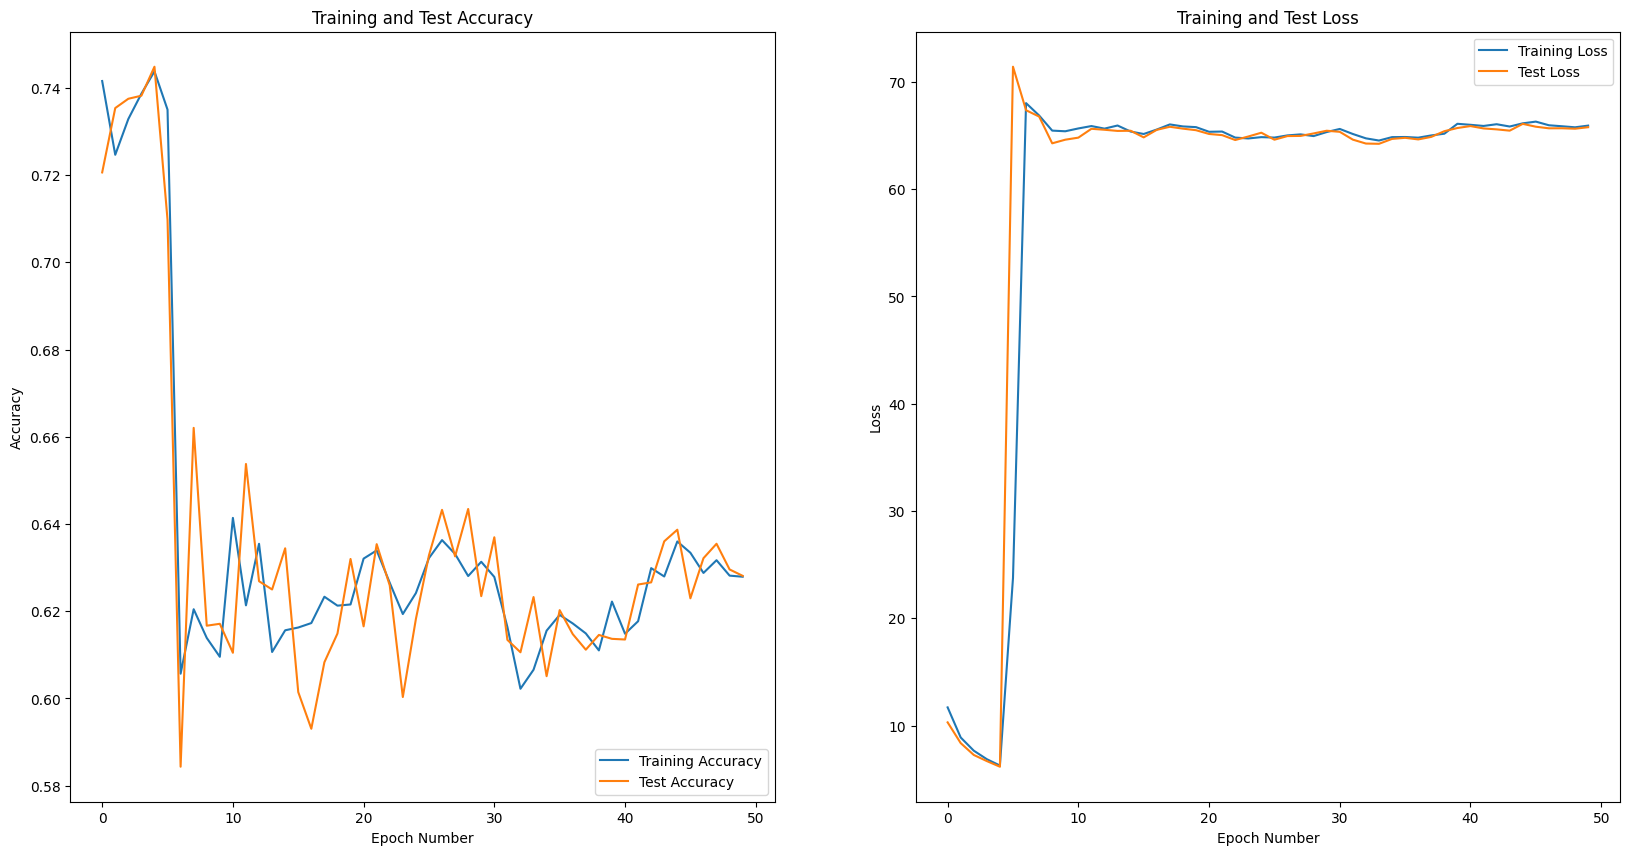

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.savefig(os.path.join(proj_model_dir, "newest_model_metrics.pdf"))

plt.show()

In [30]:
best_model = keras.models.model_from_json(model_architecture)
best_model.load_weights(os.path.join(proj_model_dir, "best_run.hdf5"))
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(decode_word(result.numpy())).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [32]:
val_result = model.evaluate(val_ds)

loss = val_result[0]
accuracy = val_result[1]
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

204/204 [==============================] - 5s 24ms/step - loss: 65.1347 - accuracy: 0.6293
Validation Loss: 65.13473510742188
Validation Accuracy: 0.6293184161186218


In [33]:
predictions = []
targets = []
for batch in val_ds:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(decode_word(label.numpy())).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in range(0, len(predictions)):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 34ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : faowahk                
Prediction: ttt                  
----------------------------------------------------------------------------------------------------
Target    : faowahk                
Prediction: tt                   
----------------------------------------------------------------------------------------------------
Target    : tiytpaaiyt              
Prediction: t                    
----------------------------------------------------------------------------------------------------
Target    : tiytpaaiyt              
Prediction: kkkkt                
----------------------------------------------------------------------------------------------------
Target    : tert                  
P